# Evaluating Matchings Produced by Various Hyperparameters and Constraints

In [1]:
import time
import argparse
import json
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import HTML

# Configuration
class Cfg:
    # Comment out the matchings you want to exclude. 
    matchings = [
        # 'assignments_all_reviewers_10_1.json',
        'assignments_all_reviewers_4.json',
        'assignments_max_4_5.json', 'assignments_q_0.75_4_5.json', 
    ]
    # 1.1 GB file
    scores_with_origin = 'scores_specter2_scincl.csv'
    root_dir = './data/'
    reviewer_archive_dir = 'archives/'

def hr(): return display(HTML('<hr>'))

In [2]:
def load_matchings_file(matchings_path):
    with open(matchings_path, 'r') as file:
        matchings = json.load(file)
    return matchings

def to_matchings_df(matchings):
    """Returns a dataframe with schema {'paper_id': 'str', 'scores': List[float], 'reviewers': List[str]}"""
    records = []
    for paper_id in matchings:
        vals = matchings[paper_id]
        scores = [np.round(v['aggregate_score'], 3) for v in vals]
        reviewers = [v['user'] for v in vals]
        records.append({'paper_id': paper_id, 'scores': scores, 'reviewers': reviewers})
    return pd.DataFrame(records)
    
def get_quality_metrics(paper_id, reviewers_list, affinity_df):
    """
    Return a record of metrics to use for quality estimation.
    returns {'max_affinity': List[float], 'max_affinity_OR': List[float]}
    """
    ix_pid = affinity_df.index.get_level_values('paper_id')
    paper_affinity_df = affinity_df[ix_pid == paper_id]
    ix_rid = paper_affinity_df.index.get_level_values('reviewer_id')
    scores = {
        'max_affinities': [], 'max_affinity_papers': [], 
        'max_affinities_OR' : [], 'max_affinity_OR_papers': []
    }
    for reviewer_id in reviewers_list:
        ss =  paper_affinity_df[ix_rid == reviewer_id].reset_index()
        if len(ss.index) == 0:
            print("WARNING", "No affinity score found for reviewer", reviewer_id, ' and paper', paper_id)
            print("Skipping!")
            return scores
        
        max_affinity_id = ss.affinity_score.idxmax()
        max_affinity, max_affinity_paper = ss.loc[max_affinity_id].affinity_score, ss.loc[max_affinity_id].reviewers_paper_id
        
        max_affinity_or, max_affinity_or_paper = 0.0, None
        ss_or = ss[ss.origin == 'OR'].reset_index()
        if len(ss_or.index) > 0:
                max_affinity_or_id = ss_or.affinity_score.idxmax()
                max_affinity_or, max_affinity_or_paper = ss_or.loc[max_affinity_or_id].affinity_score, ss_or.loc[max_affinity_or_id].reviewers_paper_id 
    
        scores['max_affinities'].append(np.round(max_affinity, 3))
        scores['max_affinities_OR'].append(np.round(max_affinity_or, 3))
        scores['max_affinity_papers'].append(max_affinity_paper)
        scores['max_affinity_OR_papers'].append(max_affinity_or_paper)
    return scores
    
def to_load_df(matchings):
    """Returns a dataframe with schema {'reviewer_id': 'str', 'paper_ids': List[str], 'scores': List[str]}."""
    # reviewer_id -> [(paper_id, score), ...]
    reviewer_to_papers = {}
    for paper_id in matchings:
        for match in matchings[paper_id]:
            reviewer = match['user']
            score = np.round(match['aggregate_score'], 3)
            val = reviewer_to_papers.get(reviewer, [])
            val.append(paper_id)
            reviewer_to_papers[reviewer] = val
    df = pd.DataFrame({'reviewer_id': list(reviewer_to_papers.keys()),
                       'paper_info': list(reviewer_to_papers.values())})
    return df

In [3]:
# paper_id: [{'aggregate_score': float, 'user': str}, ...]
all_matchings = {fname: {'matchings': load_matchings_file(os.path.join(Cfg.root_dir, fname))} for fname in Cfg.matchings}

In [4]:
affinity_df = pd.read_csv(os.path.join(Cfg.root_dir, Cfg.scores_with_origin), header=None)
affinity_df.columns = ['paper_id', 'reviewer_id', 'affinity_score', 'origin', 'reviewers_paper_id']
affinity_df.set_index(['paper_id', 'reviewer_id'], inplace=True)
affinity_df.sort_index(inplace=True)
affinity_df.sample(4)

,,affinity_score,origin,reviewers_paper_id
paper_id,reviewer_id,,,
wQfzSN2muq,~Xiangliang_Zhang1,0.485697,dblp,_5QI_KjhDl
VfWrXJtLSL,~Jie_Fu1,0.523218,OR,r1lcM3AcKm
x7zpwGCE5v,~Junyan_Duan1,0.546101,dblp,gTlHzdbOkS
u3iXuPfOVb,~Hongyu_Zhang1,0.558635,dblp,HSVLr6Lswhl


In [5]:
paper_id = 'LzLDGNgyCB'
reviewers_id = ['~Ahmad_Kazmi1']
#adf = affinity_df.reset_index()
#display(adf[adf['reviewer_id'] == '~Ahmad_Kazmi1'])
print(get_quality_metrics(paper_id, reviewers_id, affinity_df))

WARNING No affinity score found for reviewer ~Ahmad_Kazmi1  and paper LzLDGNgyCB
Skipping!
{'max_affinities': [], 'max_affinity_papers': [], 'max_affinities_OR': [], 'max_affinity_OR_papers': []}


# General Max-affinity Score Statistics

- Mean score per paper and its standard deviation.
- Lowest 5% quantile score

In [6]:
for matching_name, info in all_matchings.items():
    print(matching_name)
    matchings = info['matchings']
    mdf = to_matchings_df(matchings)
    mdf['quality_metrics'] = mdf.apply(lambda row: get_quality_metrics(row.paper_id, row.reviewers, affinity_df), axis=1)
    all_matchings[matching_name]['matchings_df'] = mdf

assignments_all_reviewers_4.json
WARNING No affinity score found for reviewer ~Ahmad_Kazmi1  and paper LzLDGNgyCB
Skipping!
WARNING No affinity score found for reviewer ~Daniele_Malitesta1  and paper SJFcCQ7MzR
Skipping!
WARNING No affinity score found for reviewer ~Amit_Kumar_Sah1  and paper lhESknBxTF
Skipping!
WARNING No affinity score found for reviewer ~Arijit_Das2  and paper oBP8vXFJNQ
Skipping!
WARNING No affinity score found for reviewer ~Dongryeol_Lee1  and paper u3iXuPfOVb
Skipping!
WARNING No affinity score found for reviewer ~Ahmad_Kazmi1  and paper uijg2dSEd7
Skipping!
WARNING No affinity score found for reviewer ~Batu_Ozturkler1  and paper zxdgD9W0P7
Skipping!
assignments_max_4_5.json
assignments_q_0.75_4_5.json


In [7]:
for matching_name, info in all_matchings.items():
    mdf = info['matchings_df']
    # Unpack
    mdf['max_affinities'] = mdf['quality_metrics'].apply(lambda x: x['max_affinities'])
    mdf['max_affinities_OR'] = mdf['quality_metrics'].apply(lambda x: x['max_affinities_OR'])
    mdf['max_affinity_papers'] = mdf['quality_metrics'].apply(lambda x: x['max_affinity_papers'])
    mdf['max_affinities_OR_papers'] = mdf['quality_metrics'].apply(lambda x: x['max_affinity_OR_papers'])
    # Compute mean
    mdf['mean(max_affinities)'] = mdf['max_affinities'].apply(lambda x: np.mean(x))
    mdf['mean(max_affinities_OR)'] = mdf['max_affinities_OR'].apply(lambda x: np.mean(x))
    mdf['mean_top2(max_affinities)'] = mdf['max_affinities'].apply(lambda x: np.mean(np.sort(x)[-2:]))
    mdf['mean_top2(max_affinities_OR)'] = mdf['max_affinities_OR'].apply(lambda x: np.mean(np.sort(x)[-2:]))
    mdf['std(max_affinities)'] = mdf['max_affinities'].apply(lambda x: np.std(x))
    mdf['std(max_affinities_OR)'] = mdf['max_affinities_OR'].apply(lambda x: np.std(x))
    mdf['n_reviewers'] = mdf['scores'].apply(lambda x: len(x))
    display(mdf[['paper_id', 'reviewers', 'max_affinities', 'mean_top2(max_affinities)', 'max_affinity_papers']].head(5))

/home/don/.miniforge3/envs/openreview-matcher/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/don/.miniforge3/envs/openreview-matcher/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/don/.miniforge3/envs/openreview-matcher/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/don/.miniforge3/envs/openreview-matcher/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/don/.miniforge3/envs/openreview-matcher/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/don/.minifo

,paper_id,reviewers,max_affinities,mean_top2(max_affinities),max_affinity_papers
0,0bpM5H69Dj,"[~Yang_Jiao5, ~Yuhang_Zang1, ~Yuxin_Xiong1, ~Z...","[0.861, 0.874, 0.716, 0.873]",0.8735,"[v5Un2QqnRf, evP9mxNNxJ, zJ7SFZWRwA, 3MQhRJiYho]"
1,2dEH0u8w0b,"[~Bo_Kang1, ~Mathieu_Carrière1, ~Serguei_Baran...","[0.779, 0.761, 0.791, 0.824]",0.8075,"[P1QUVhOtEFP, mYx4BLhiRw_, lIu-ixf-Tzf, IS7xWm..."
2,2j6CFbIWKq,"[~Xu_Chen16, ~Yangbangyan_Jiang1, ~Zhepeng_Wan...","[0.737, 0.779, 0.665, 0.779]",0.7790,"[R5uE2_Ilhck, sp2HFfcOJp, sPgkw-XgKC, sp2HFfcOJp]"
3,3ajK5xplDL,"[~Ashkan_Norouzi-Fard2, ~César_Sabater1, ~Elia...","[0.831, 0.8, 0.83, 0.857]",0.8440,"[wQVjGP5NbP9, UErJ348uyNp_, yKl4KclLwjB, ayBKR..."
4,3or9yXWrss,"[~Alexander_Tong1, ~Bao_Nguyen2, ~Jiying_Zhang...","[0.802, 0.732, 0.637, 0.793]",0.7975,"[SFfkurlLn15, Iyve2ycvGZ, NFsUrbX54KO, fE3RqiF..."


,paper_id,reviewers,max_affinities,mean_top2(max_affinities),max_affinity_papers
0,0bpM5H69Dj,"[~Karan_Sikka1, ~Qi_Chen2, ~Qinyu_Zhao1, ~Shua...","[0.801, 0.701, 0.826, 0.84]",0.8330,"[N23cmqtO0F, EMCXCTsmSx, c0XcCLa2L5, C89wXmkCER2]"
1,2dEH0u8w0b,"[~Antoine_Gourru1, ~Jiayan_Qiu1, ~Neil_Shah2, ...","[0.718, 0.828, 0.759, 0.756]",0.7935,"[ovha5L1PIbv, eoUJkCzv3PH, He7UIpiEq_O, nxeDCn..."
2,2j6CFbIWKq,"[~Haitao_Lin2, ~Junghyun_Lee1, ~Mao_Xiaojun1, ...","[0.778, 0.737, 0.766, 0.732]",0.7720,"[iox4AjpZ15, XAswkinvl-, jAk7Mg9EvwJ, cG2BAbFnA4]"
3,3ajK5xplDL,"[~Disha_Makhija1, ~Mao_Xiaojun1, ~Peilin_Zhong...","[0.743, 0.808, 0.894, 0.789]",0.8510,"[hilGwNabqB, P2nxGgBzSvY, 5yU7rYxm49, IK2cR89z45]"
4,3or9yXWrss,"[~Charlotte_Bunne1, ~Kyungjae_Lee1, ~Pu_Ren1, ...","[0.768, 0.757, 0.737, 0.772]",0.7700,"[K4wifbtx95, pdPojupG6Z, JCmZwAN5Fm, c6Ta9WB881]"


,paper_id,reviewers,max_affinities,mean_top2(max_affinities),max_affinity_papers
0,0bpM5H69Dj,"[~Emanuele_Bugliarello1, ~Qinyu_Zhao1, ~Shuang...","[0.817, 0.826, 0.84, 0.858]",0.8490,"[c6TcIwVeLL_, c0XcCLa2L5, C89wXmkCER2, 1jBDAva..."
1,2dEH0u8w0b,"[~Baoyu_Jing1, ~Haitao_Lin2, ~Ming_Li15, ~Tobi...","[0.703, 0.785, 0.699, 0.681]",0.7440,"[PMuX-aUoLuQ, mL2lz8WWuB, caYcl0F0MsZ, xvblqTk..."
2,2j6CFbIWKq,"[~Chen_Gong5, ~Hongying_Liu2, ~Shikun_Li1, ~Yu...","[0.837, 0.732, 0.706, 0.732]",0.7845,"[1nBeWhDVde_, BklDO1HYPS, Q39Vze0Nlj6, cG2BAbF..."
3,3ajK5xplDL,"[~Disha_Makhija1, ~Jihun_Hamm1, ~Mao_Xiaojun1,...","[0.743, 0.784, 0.808, 0.676]",0.7960,"[hilGwNabqB, ocp92wSKuH, P2nxGgBzSvY, s4Wx2qXhv9]"
4,3or9yXWrss,"[~Abdul_Fatir_Ansari2, ~Khai_Nguyen1, ~Pu_Ren1...","[0.774, 0.691, 0.737, 0.687]",0.7555,"[1X03klAkwJ-, HCMsBO-mVix, JCmZwAN5Fm, fQbB0tr..."


Matchings: assignments_all_reviewers_4.json


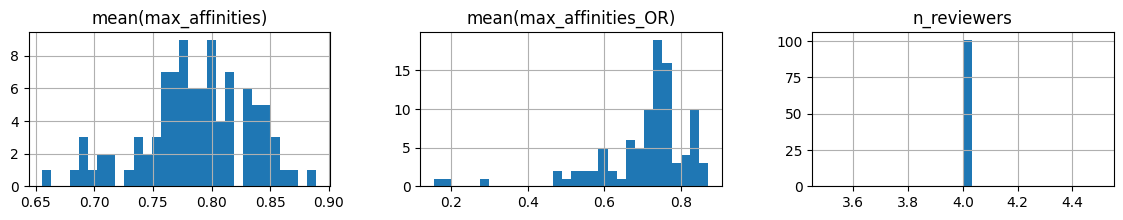

Matchings: assignments_max_4_5.json


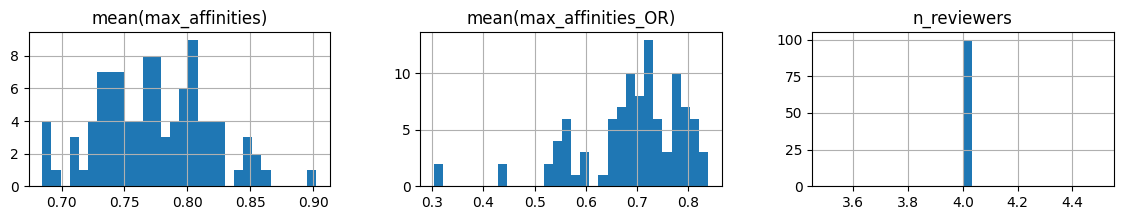

Matchings: assignments_q_0.75_4_5.json


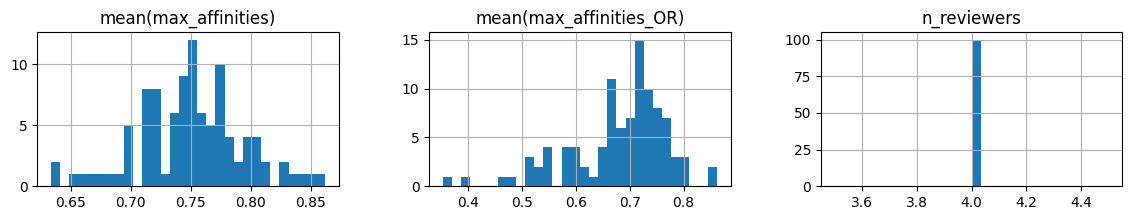

In [8]:
def plot_score_distr(df): 
    fig, axs = plt.subplots(1, 3, figsize=(14, 2))
    df.hist(column='mean(max_affinities)', bins=30, ax=axs[0])
    df.hist(column='mean(max_affinities_OR)', bins=30, ax=axs[1]);
    df.hist(column='n_reviewers', bins=30, ax=axs[2]);
    plt.show()

for matching_name, info in all_matchings.items():
    print("Matchings:", matching_name)
    sdf = info['matchings_df']
    plot_score_distr(sdf)
    hr()


In [9]:
def quantile_report(df, quantile, column='mean_paper_score'):
    lowq_mean_score = df[column].quantile(quantile)
    highq_mean_score = df[column].quantile(1-quantile)
    return lowq_mean_score, highq_mean_score


quantile = 0.05
records = []
score_col, std_col = 'mean(max_affinities)', 'std(max_affinities)'
for matching_name, info in all_matchings.items():
    scores_df = info['matchings_df']
    # display(scores_df.sample(3))
    low_score, high_score = quantile_report(scores_df, quantile, column=score_col)
    # Not strict inequalities;
    low_count = len(scores_df[scores_df[score_col] >= low_score])
    high_count = len(scores_df[scores_df[score_col] >= high_score])
    records.append({
        'matching_name': matching_name, 
        f'top {(quantile) * 100: .0f}% quantile score': high_score.round(2),
        f'top {(1 - quantile) * 100:.0f}% quantile score': low_score.round(2),
    })
print("Using evaluation score:", score_col)
display(pd.DataFrame(records))

hr()

quantile = 0.05
records = []
score_col, std_col = 'mean(max_affinities_OR)', 'std(max_affinities_OR)'
for matching_name, info in all_matchings.items():
    scores_df = info['matchings_df']
    # display(scores_df.sample(3))
    low_score, high_score = quantile_report(scores_df, quantile, column=score_col)
    # Not strict inequalities;
    low_count = len(scores_df[scores_df[score_col] >= low_score])
    high_count = len(scores_df[scores_df[score_col] >= high_score])
    records.append({
        'matching_name': matching_name, 
        f'top {(quantile) * 100: .0f}% quantile score': high_score.round(2),
        f'top {(1 - quantile) * 100:.0f}% quantile score': low_score.round(2),
    })
print("Using evaluation score:", score_col)
display(pd.DataFrame(records))


Using evaluation score: mean(max_affinities)


,matching_name,top 5% quantile score,top 95% quantile score
0,assignments_all_reviewers_4.json,0.85,0.70
1,assignments_max_4_5.json,0.85,0.71
2,assignments_q_0.75_4_5.json,0.83,0.68


Using evaluation score: mean(max_affinities_OR)


,matching_name,top 5% quantile score,top 95% quantile score
0,assignments_all_reviewers_4.json,0.84,0.49
1,assignments_max_4_5.json,0.81,0.53
2,assignments_q_0.75_4_5.json,0.79,0.51


# Inspect Tail Scores, Test and Flag Potential Outliers

For tail papers, check if
1. Flag one or more reviewers with a particularly low score for a given paper. Low defined with respect to mean score for the paper.
2. If there are no high-affinity reviewers for some papers, flag them.
3. ?

In [10]:
# Note: Manually selected looking at the distribution of std deviations.
score_list_col, score_col, std_col, max_std = 'max_affinities', 'mean(max_affinities)', 'std(max_affinities)', 0.03
display_cols = ['paper_id', 'reviewers', score_list_col, score_col, std_col, 'mean_top2(max_affinities)']
for matching_name, info in all_matchings.items():
    df = info['matchings_df']
    low_score, high_score = quantile_report(df, quantile, column=score_col)
    low_df = df[df[score_col] <= low_score]
    e_df = low_df[low_df[std_col] > max_std].copy()
    print(matching_name)
    # Are these papers low tail because some of the reviewrs have low scores?
    if len(e_df) == 0:
        print(f"\tTest 1: There are NO reviewers with lowscore (score <= mean(paper) - std, std: {max_std})")
    else:
        # 1-std away from mean. 
        print(f"\tTest 1: There are reviewers with low score (score <= mean(paper) - std, std: {max_std})")
        e_df['outlier_scores'] = e_df[score_list_col].apply(lambda scores: [x for x in scores if x < np.mean(scores) - max_std])
        display(e_df[display_cols + ['outlier_scores']])
    # Do all the reviewers have low score? Then the quality of overall reviews might be low.
    f_df = low_df[low_df[std_col] < max_std].copy()
    if len(f_df) > 0:
        print("\tTest 2: All the reviewers have low individual scores. " +
                  f"There are no 'high-affinity' reviewers. (std: {max_std})")
        display(f_df[display_cols])
    else:
        print("\tTest 2: There is at least one high affinity reviewer")
    hr()

assignments_all_reviewers_4.json
	Test 1: There are reviewers with low score (score <= mean(paper) - std, std: 0.03)


,paper_id,reviewers,max_affinities,mean(max_affinities),std(max_affinities),mean_top2(max_affinities),outlier_scores
21,CtFdaTTAwh,"[~Aaqib_Saeed1, ~Yixuan_Chen1, ~Zhuangdi_Zhu1,...","[0.826, 0.633, 0.579, 0.714]",0.68800,0.093040,0.7700,"[0.633, 0.579]"
25,G8zDeKOp0R,"[~Guangmo_Tong1, ~Karsten_Roth1, ~Runzhong_Wan...","[0.673, 0.78, 0.675, 0.648]",0.69400,0.050779,0.7275,[0.648]
31,LUXMAeCeWs,"[~Alexandru_Tifrea1, ~Chengchao_Shen2, ~Yue_Su...","[0.732, 0.731, 0.705, 0.59]",0.68950,0.058457,0.7315,[0.59]
39,Pjunw0i20t,"[~Apaar_Sadhwani1, ~Issam_H._Laradji1, ~Yang_L...","[0.521, 0.673, 0.742, 0.687]",0.65575,0.081962,0.7145,[0.521]
85,sBRJXfjIYK,"[~Dmitrii_Marin2, ~Hwee_Kuan_Lee1, ~Riccardo_M...","[0.693, 0.668, 0.734, 0.648]",0.68575,0.032097,0.7135,[0.648]


	Test 2: There is at least one high affinity reviewer


assignments_max_4_5.json
	Test 1: There are reviewers with low score (score <= mean(paper) - std, std: 0.03)


,paper_id,reviewers,max_affinities,mean(max_affinities),std(max_affinities),mean_top2(max_affinities),outlier_scores
15,BJpmRDdA98,"[~Johannes_Fürnkranz1, ~Junghyun_Lee1, ~Magda_...","[0.77, 0.667, 0.692, 0.627]",0.68900,0.052197,0.7310,[0.627]
41,Ri9Hgkvlys,"[~Baoyu_Jing1, ~Eldan_Cohen1, ~Shinichi_Shirak...","[0.754, 0.643, 0.721, 0.655]",0.69325,0.045959,0.7375,"[0.643, 0.655]"
94,x7zpwGCE5v,"[~Jihun_Hamm1, ~Ming_Li15, ~Mingxuan_Ju1, ~Yun...","[0.708, 0.743, 0.675, 0.63]",0.68900,0.041695,0.7255,[0.63]


	Test 2: All the reviewers have low individual scores. There are no 'high-affinity' reviewers. (std: 0.03)


,paper_id,reviewers,max_affinities,mean(max_affinities),std(max_affinities),mean_top2(max_affinities)
10,8QJSTDII5d,"[~Chaitanya_Krishna_Joshi1, ~Phillip_Lippe1, ~...","[0.701, 0.671, 0.712, 0.655]",0.68475,0.022808,0.7065
75,kyWZXZ5ZHd,"[~Johannes_Fürnkranz1, ~Magda_Gregorova2, ~Par...","[0.691, 0.666, 0.665, 0.717]",0.68475,0.021335,0.7040


assignments_q_0.75_4_5.json
	Test 1: There are reviewers with low score (score <= mean(paper) - std, std: 0.03)


,paper_id,reviewers,max_affinities,mean(max_affinities),std(max_affinities),mean_top2(max_affinities),outlier_scores
10,8QJSTDII5d,"[~Parth_Kashyap_Thaker1, ~Sebastian_Mair1, ~Ta...","[0.569, 0.642, 0.705, 0.622]",0.6345,0.048665,0.6735,[0.569]
68,g8AigOTNXL,"[~Abdul_Fatir_Ansari2, ~Amrit_Bedi1, ~Shuangru...","[0.721, 0.667, 0.585, 0.647]",0.6550,0.048642,0.6940,[0.585]


	Test 2: All the reviewers have low individual scores. There are no 'high-affinity' reviewers. (std: 0.03)


,paper_id,reviewers,max_affinities,mean(max_affinities),std(max_affinities),mean_top2(max_affinities)
15,BJpmRDdA98,"[~Antoine_Gourru1, ~Lanjun_Wang1, ~Marek_Elias...","[0.611, 0.68, 0.627, 0.617]",0.63375,0.027307,0.6535
75,kyWZXZ5ZHd,"[~Haitao_Lin2, ~Hongying_Liu2, ~Magda_Gregorov...","[0.654, 0.707, 0.666, 0.641]",0.66700,0.024729,0.6865
94,x7zpwGCE5v,"[~Baoyu_Jing1, ~Kun_He1, ~Sergey_Shuvaev1, ~Xu...","[0.649, 0.675, 0.628, 0.683]",0.65875,0.021753,0.6790


# General Reviewer Load 

assignments_all_reviewers_4.json


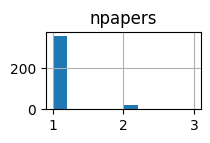

assignments_max_4_5.json


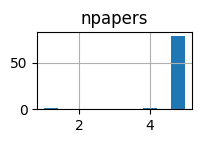

assignments_q_0.75_4_5.json


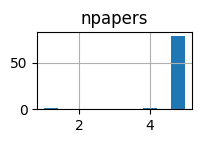

In [11]:
for matching_name, info in all_matchings.items():
    print(matching_name)
    matchings = info['matchings']
    load_df = to_load_df(matchings)
    load_df['npapers'] = load_df['paper_info'].apply(lambda x: len(x))
    load_df.hist(column='npapers', figsize=(2,1))
    info['load_df'] = load_df
    all_matchings[matching_name] = info
    plt.show()
    hr()

# Compare Changes in Matchings

Given two set of assigned reviewers (A, B) for a given `paper_id`, we can define
1. Set differences: $A-B$ and $B-A$
3. $\frac{A\cap B}{A\cup B}$

The some simple statistics can be computed to get a sense of how 'different' the two schemes are, such as;
1. % of papers where the matchings did not change; $A-B = B-A = 0$.
2. % of papers where the matchings completely changed $\frac{A\cap B}{A\cup B} = 0$.
3. For the papers where the matchings changed, how much did the corresponding mean-score change.
4. ?


In [12]:
import itertools

def unique_product(sets):
    result = set()
    for prod in itertools.product(sets, sets):
        result.add(tuple(sorted(prod)))
    return result

def compute_pairwise_stats(df_a, df_b, score_col):
    df_a = df_a.set_index('paper_id')
    df_b = df_b.set_index('paper_id')
    df_a.columns = [c + '_a' for c in df_a.columns]
    df_b.columns = [c + '_b' for c in df_b.columns]
    df_join = df_b.join(df_a)
    df_join['set_reviewers_b'] = df_join['reviewers_b'].apply(lambda x: set(x))
    df_join['set_reviewers_a'] = df_join['reviewers_a'].apply(lambda x: set(x))
    df_join['set_union_ab'] = df_join.apply(lambda x: x.set_reviewers_a.union(x.set_reviewers_b), axis=1)
    df_join['set_inter_ab'] = df_join.apply(lambda x: x.set_reviewers_a.intersection(x.set_reviewers_b), axis=1)
    df_join['len(a-b)'] = (df_join['set_reviewers_a'] - df_join['set_reviewers_b']).apply(lambda x: len(x))
    df_join['len(b-a)'] = (df_join['set_reviewers_b'] - df_join['set_reviewers_a']).apply(lambda x: len(x))
    df_join['inter/union'] = df_join.apply(lambda x: len(x.set_inter_ab) / len(x.set_union_ab), axis=1)
    df_join['mean_score_a-mean_score_b'] = df_join.apply(lambda x: x[score_col + '_a'] - x[score_col + '_b'], axis=1)
    df_join['mean_score_b-mean_score_a'] = df_join.apply(lambda x: x[score_col + '_b'] - x[score_col + '_a'], axis=1)
    return df_join[['len(a-b)', 'len(b-a)', 'inter/union', 'mean_score_b-mean_score_a', 'mean_score_a-mean_score_b']]
    
sources = list(all_matchings.keys())
source_pairs = unique_product(sources)

a = assignments_max_4_5.json vs b = assignments_q_0.75_4_5.json Using evaluation score: mean(max_affinities)
Histogram of changes in assignments between A and B


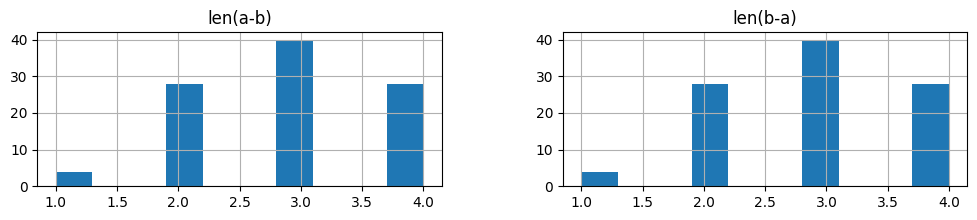

Boxplot of score change vs #changes in assignments


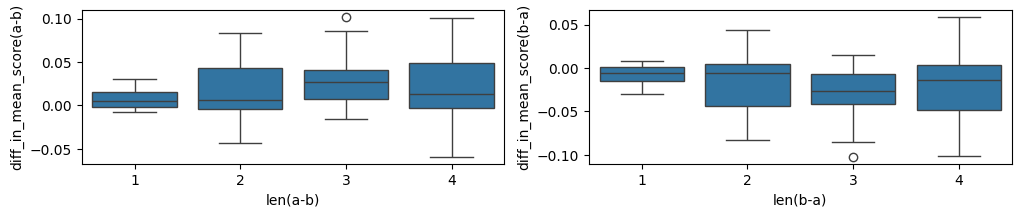

a = assignments_all_reviewers_4.json vs b = assignments_q_0.75_4_5.json Using evaluation score: mean(max_affinities)
Histogram of changes in assignments between A and B


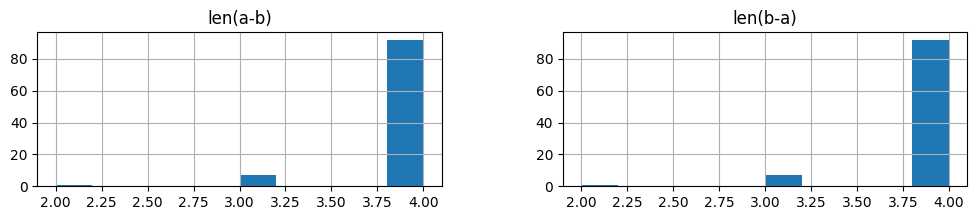

Boxplot of score change vs #changes in assignments


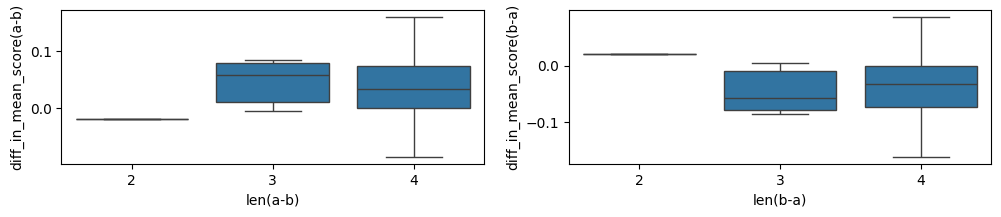

a = assignments_all_reviewers_4.json vs b = assignments_max_4_5.json Using evaluation score: mean(max_affinities)
Histogram of changes in assignments between A and B


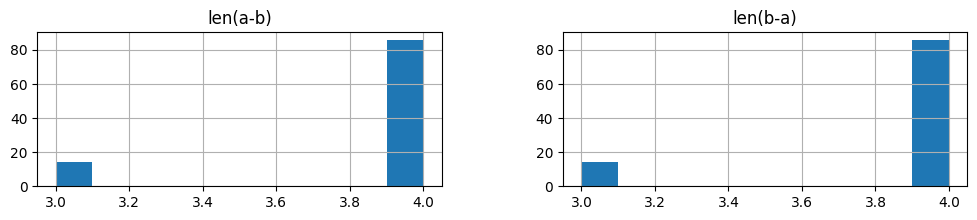

Boxplot of score change vs #changes in assignments


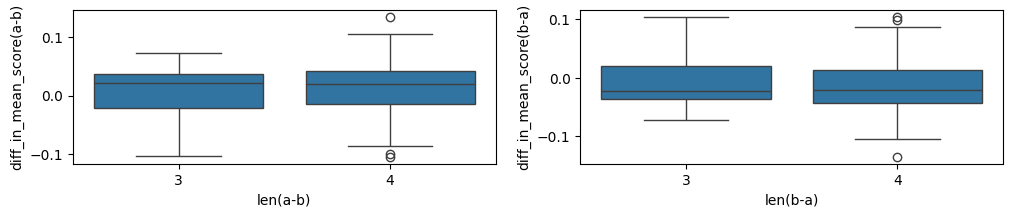

In [13]:
score_col = 'mean(max_affinities)'
for (key_a, key_b) in source_pairs:
    # Debugging
    if key_a == key_b: continue
        
    df_a, df_b = all_matchings[key_a]['matchings_df'].copy(), all_matchings[key_b]['matchings_df'].copy()
    print("a =", key_a, "vs", "b =", key_b, 'Using evaluation score:', score_col)
    stats = compute_pairwise_stats(df_a, df_b, score_col)
    # Visualize
    fig, axs = plt.subplots(1, 2, figsize=(12, 2))
    # If sizes of a and b are same, then these are identical
    stats.hist(column='len(a-b)', ax=axs[0])
    stats.hist(column='len(b-a)', ax=axs[1])
    print("Histogram of changes in assignments between A and B")
    #stats.hist(column='inter/union', ax=axs[2])
    plt.show()
    print("Boxplot of score change vs #changes in assignments")
    fig, axs = plt.subplots(1, 2, figsize=(12,2))
    # Note: Positive change means assignment under A was better
    sns.boxplot(data=stats, x='len(a-b)', y='mean_score_a-mean_score_b', ax=axs[0])
    axs[0].set_ylabel("diff_in_mean_score(a-b)")
    sns.boxplot(data=stats, x='len(b-a)', y='mean_score_b-mean_score_a', ax=axs[1])
    axs[1].set_ylabel("diff_in_mean_score(b-a)")
    plt.show()
    hr()
  

1. Most of the assignments seem to change when going from A to B. There are very few cases with 0-change.
2. When going from `a=assignments_max_4_5.json` to `b=assignments_q_0.75_4_5.json` (lower right plot) the score differences seem to be slightly worse on average.
3. More generally, these plots don't seem to be particularly informative.

# Exporting Sample Assignments for Manual Inspection

In [14]:
# Get a set of paper_ids from one of the matchings
sample_size = 25
for matching_name, info in all_matchings.items():
    mdf = info['matchings_df']
    paper_ids = mdf.sample(sample_size).reset_index().paper_id
    break


In [15]:
sample_matchings = {}
# For these paper_ids, get the matchings under all settings
for matching_name, info in all_matchings.items():
    mdf = info['matchings_df']
    sample_df = mdf[mdf.paper_id.isin(paper_ids)]
    sample_matchings[matching_name] = sample_df

In [16]:
import pickle
with open('./data/sample_matchings_manual.pkl', 'wb') as f:
    pickle.dump(sample_matchings, f)

In [17]:
display(sample_df)

,paper_id,scores,reviewers,quality_metrics,max_affinities,max_affinities_OR,max_affinity_papers,max_affinities_OR_papers,mean(max_affinities),mean(max_affinities_OR),mean_top2(max_affinities),mean_top2(max_affinities_OR),std(max_affinities),std(max_affinities_OR),n_reviewers
4,3or9yXWrss,"[0.706, 0.644, 0.687, 0.6]","[~Abdul_Fatir_Ansari2, ~Khai_Nguyen1, ~Pu_Ren1...","{'max_affinities': [0.774, 0.691, 0.737, 0.687...","[0.774, 0.691, 0.737, 0.687]","[0.727, 0.689, 0.7, 0.687]","[1X03klAkwJ-, HCMsBO-mVix, JCmZwAN5Fm, fQbB0tr...","[zjSeBTEdXp1, hwBPHlH9tK, MuPlJ9fT4b, fQbB0tr3...",0.72225,0.70075,0.7555,0.7135,0.035759,0.015943,4
8,5etljbYMy9,"[0.714, 0.707, 0.689, 0.693]","[~Guojun_Zhang1, ~Jiayan_Qiu1, ~Shikun_Li1, ~S...","{'max_affinities': [0.758, 0.737, 0.736, 0.726...","[0.758, 0.737, 0.736, 0.726]","[0.758, 0.0, 0.561, 0.609]","[WHIwUjbJEh, 3DffDR6s3D, ZgN1sTRpDoj, GeZqmOa8_b]","[WHIwUjbJEh, None, GwXrGy_vc8m, axX62CQJpa]",0.73925,0.48200,0.7475,0.6835,0.011648,0.287607,4
10,8QJSTDII5d,"[0.566, 0.607, 0.61, 0.622]","[~Parth_Kashyap_Thaker1, ~Sebastian_Mair1, ~Ta...","{'max_affinities': [0.569, 0.642, 0.705, 0.622...","[0.569, 0.642, 0.705, 0.622]","[0.399, 0.615, 0.702, 0.622]","[p4RhQhC6LI, S4ABH5yC1pA, cK4rwl3Q867, ySCL-NG...","[KQYodS0W0j, L7C0XG9eSM, eqOWfGGo7Z, ySCL-NG_I3]",0.63450,0.58450,0.6735,0.6620,0.048665,0.112420,4
26,Ij6VpQX9P3,"[0.751, 0.752, 1.531, 0.765]","[~Jacopo_Castellini1, ~Junshan_Zhang1, ~Maryam...","{'max_affinities': [0.786, 0.804, 0.781, 0.835...","[0.786, 0.804, 0.781, 0.835]","[0.0, 0.804, 0.781, 0.835]","[wlNtrGq32aX, EBn0uInJZWh, aM7l2S2s5pk, BkeYSl...","[None, EBn0uInJZWh, aM7l2S2s5pk, BkeYSlrYwH]",0.80150,0.60500,0.8195,0.8195,0.021148,0.349822,4
27,IwjYn2qZWc,"[0.688, 0.691, 0.651, 0.675]","[~Denis_Kuznedelev1, ~Muhammed_Fatih_Balin1, ~...","{'max_affinities': [0.772, 0.767, 0.767, 0.73]...","[0.772, 0.767, 0.767, 0.73]","[0.688, 0.767, 0.68, 0.73]","[GKR7ysnysN, WWDsbsgyhS, g5ToGAd3xam, EWcybWr3MR]","[zYWtq_HUCoi, WWDsbsgyhS, 4jqff9QeUD, EWcybWr3MR]",0.75900,0.71625,0.7695,0.7485,0.016867,0.034917,4
31,LUXMAeCeWs,"[0.679, 1.366, 0.689, 0.716]","[~Chen_Gong5, ~Danqing_Wang1, ~Johannes_Fürnkr...","{'max_affinities': [0.773, 0.708, 0.784, 0.757...","[0.773, 0.708, 0.784, 0.757]","[0.748, 0.708, 0.634, 0.757]","[9yyCLZXSorK, MEByW1upLk, Y1QDCkwePjR, imav8hh...","[4ApXq4y81kY, MEByW1upLk, XWfjugkXzN, imav8hhe...",0.75550,0.71175,0.7785,0.7525,0.029056,0.048530,4
34,N6whB3Ayrz,"[0.694, 0.688, 0.703, 0.665]","[~Alexandre_ARAUJO1, ~Junshan_Zhang1, ~Takahar...","{'max_affinities': [0.815, 0.753, 0.81, 0.716]...","[0.815, 0.753, 0.81, 0.716]","[0.793, 0.753, 0.81, 0.711]","[hbQROB_6Lh0, k7nYm2yU5i, xDaoT2zlJ0r, gwTR-Kq...","[k71IGLC8cfc, k7nYm2yU5i, xDaoT2zlJ0r, c6Ta9WB...",0.77350,0.76675,0.8125,0.8015,0.041173,0.038265,4
39,Pjunw0i20t,"[1.0, 0.67, 0.628, 1.625]","[~Apaar_Sadhwani1, ~Emanuele_Bugliarello1, ~Jo...","{'max_affinities': [0.521, 0.691, 0.748, 0.742...","[0.521, 0.691, 0.748, 0.742]","[0.5, 0.682, 0.748, 0.742]","[OnwLS5eoNlL, Ml3ciQ4LZmP, yO4cAfFjlp, QC7tHi7...","[gBpYGXH9J7F, UECSdvL8U7, yO4cAfFjlp, QC7tHi7m1H]",0.67550,0.66800,0.7450,0.7450,0.091909,0.100369,4
48,W5fefNsmUi,"[0.723, 0.698, 0.638, 0.62]","[~Andrew_Bai2, ~Chenghao_Liu1, ~Guodong_Long2,...","{'max_affinities': [0.724, 0.815, 0.814, 0.708...","[0.724, 0.815, 0.814, 0.708]","[0.722, 0.815, 0.814, 0.708]","[XntK7t1DS1, zx_uX-BO7CH, gPWtHmCaBiY, 2E6OK8c...","[P3Lyun7CZs, zx_uX-BO7CH, gPWtHmCaBiY, 2E6OK8c...",0.76525,0.76475,0.8145,0.8145,0.049575,0.049997,4
50,XXWktpaL1o,"[0.698, 0.637, 0.675, 0.65]","[~Danqing_Wang1, ~Jacopo_Castellini1, ~Vladimi...","{'max_affinities': [0.733, 0.655, 0.811, 0.65]...","[0.733, 0.655, 0.811, 0.65]","[0.706, 0.0, 0.811, 0.65]","[EFTCThBbUG, SpYqpIbI34a, dhFHO90INk, ySCL-NG_I3]","[ajOSNLwqssu, None, dhFHO90INk, ySCL-NG_I3]",0.71225,0.54175,0.7720,0.7585,0.065831,0.318074,4
